### <strong>POPQUORN</strong>
<strong>Po</strong>tato-<strong>P</strong>rolific dataset for <strong>Qu</strong>estion-Answering, <strong>O</strong>ffensiveness, text <strong>R</strong>ewriting and politeness rating with demographic <strong>N</strong>uance

[Source](https://github.com/Jiaxin-Pei/potato-prolific-dataset)
___

Comprises <strong>four NLP tasks</strong>:
1. Offensiveness rating
2. Question Answering
3. Text rewriting / Style transfer
4. Politeness rating

### <strong>4.</strong> Politeness Rating

* Done after the email rewriting task
* Uses `1372` original emails from the [Enron](https://www.kaggle.com/datasets/wcukierski/enron-email-dataset) dataset and `2346` revised emails
* Annotators were given `50` emails and asked "Consider you read this email from a colleague, how polite do you think it is?" (`1-5`)
* Analysis and findings
    * Krippendorff's $\alpha$ $\approx$ `0.43`, "moderate to low agreement"
    * Overall politeness ratings are `2.8` and `3.6` for original and revised emails
    * Use of a linear mixed-effect model
        * Variables for gender, age, education and ethnicity as fixed effects
        * Instance as the random effect

    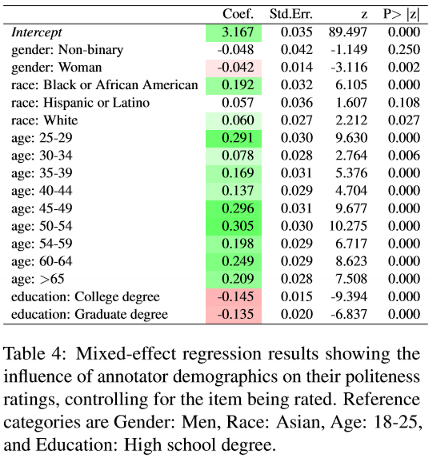

In [1]:
from IPython.display import display, HTML
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import krippendorff
import pandas as pd
import numpy as np
import copy
import json
import os

%matplotlib inline

In [2]:
path_to_dirs = '../../../data/Potato-Prolific-Dataset/dataset'
file_name = 'raw_data.csv'
sample_size=10

In [3]:
path_to_data = f'{path_to_dirs}/politeness_rating/{file_name}'

df = pd.read_csv(path_to_data)
df

,instance_id,user_id,text,politeness,gender,race,age,occupation,education
0,3104,0,Can you anticipate what's next in the WWF ?\r\...,1.0,Woman,White,25-29,Employed,College degree
1,2888,0,"Good Morning,\r\n\r\n\r\n\r\nCan you help me p...",3.0,Woman,White,25-29,Employed,College degree
2,3646,0,"Hey Joseph Step,\r\n\r\n\r\n\r\nI wish you a v...",4.0,Woman,White,25-29,Employed,College degree
3,3210,0,"I'll keep reviewing the B plan just in case, b...",4.0,Woman,White,25-29,Employed,College degree
4,3483,0,"Hey bunda,\r\nHow are you doing this morning?\...",2.0,Woman,White,25-29,Employed,College degree
...,...,...,...,...,...,...,...,...,...
25037,200,505,Add J Wolfe to the next report please.,2.0,Man,Black or African American,50-54,Employed,College degree
25038,3465,505,Results - no execute ID know for winner.,1.0,Man,Black or African American,50-54,Employed,College degree
25039,2946,505,"I'm busy on Friday, June 1st. Perhaps you coul...",2.0,Man,Black or African American,50-54,Employed,College degree
25040,3302,505,"Hi Paul,\r\nAny luck with the draft of the ABB...",5.0,Man,Black or African American,50-54,Employed,College degree


### 4.1 General stats

In [4]:
# Number of instances, number of annotators

num_inst = df['instance_id'].nunique()
num_annotr = df['user_id'].nunique()
annotn_options = sorted(df['politeness'].unique())

print(f"Number of instances: {num_inst}")
print(f"Number of annotators: {num_annotr}")
print(f"Annotation options: {annotn_options}")

Number of instances: 3718
Number of annotators: 506
Annotation options: [1.0, 2.0, 3.0, 4.0, 5.0]


In [5]:
# Number of annotations per instance

num_annotn_per_inst = df.groupby('instance_id')['user_id'].nunique() # or .size() instead of ['user_id'].nunique()
print(f"Number of annotations per instance:\n{num_annotn_per_inst.mean():.2f} MEAN, {num_annotn_per_inst.std():.2f} STD")
print(f"Fewest annotations: {num_annotn_per_inst.min()}")
print(f"Most annotations: {num_annotn_per_inst.max()}")

Number of annotations per instance:
6.74 MEAN, 0.71 STD
Fewest annotations: 3
Most annotations: 8


In [6]:
# Number of annotations per annotator

num_annotn_per_annotr = df['user_id'].value_counts()
print(f"Number of annotations per annotator:\n{num_annotn_per_annotr.mean():.2f} MEAN, {num_annotn_per_annotr.std():.2f} STD")
print(f"Fewest annotations: {num_annotn_per_annotr.min()}")
print(f"Most annotations: {num_annotn_per_annotr.max()}")

Number of annotations per annotator:
49.49 MEAN, 1.50 STD
Fewest annotations: 36
Most annotations: 50


In [7]:
# Instance text lengths

inst_texts = df['text'].unique()
inst_text_lengths_char = [len(text) for text in inst_texts]
inst_text_lengths = [len(text.split()) for text in inst_texts]

print(f"Instance text lengths (chars):\n{np.mean(inst_text_lengths_char):.2f} MEAN, {np.std(inst_text_lengths_char):.2f} STD")
print(f"Instance text lengths (words):\n{np.mean(inst_text_lengths):.2f} MEAN, {np.std(inst_text_lengths):.2f} STD")

Instance text lengths (chars):
191.27 MEAN, 139.88 STD
Instance text lengths (words):
34.27 MEAN, 23.85 STD


In [8]:
# NaN entries

num_nan = df.isna().sum().sum()
print(f"Number of NaN entries overall: {num_nan}")

Number of NaN entries overall: 0


### 4.2 Sociodemographic information

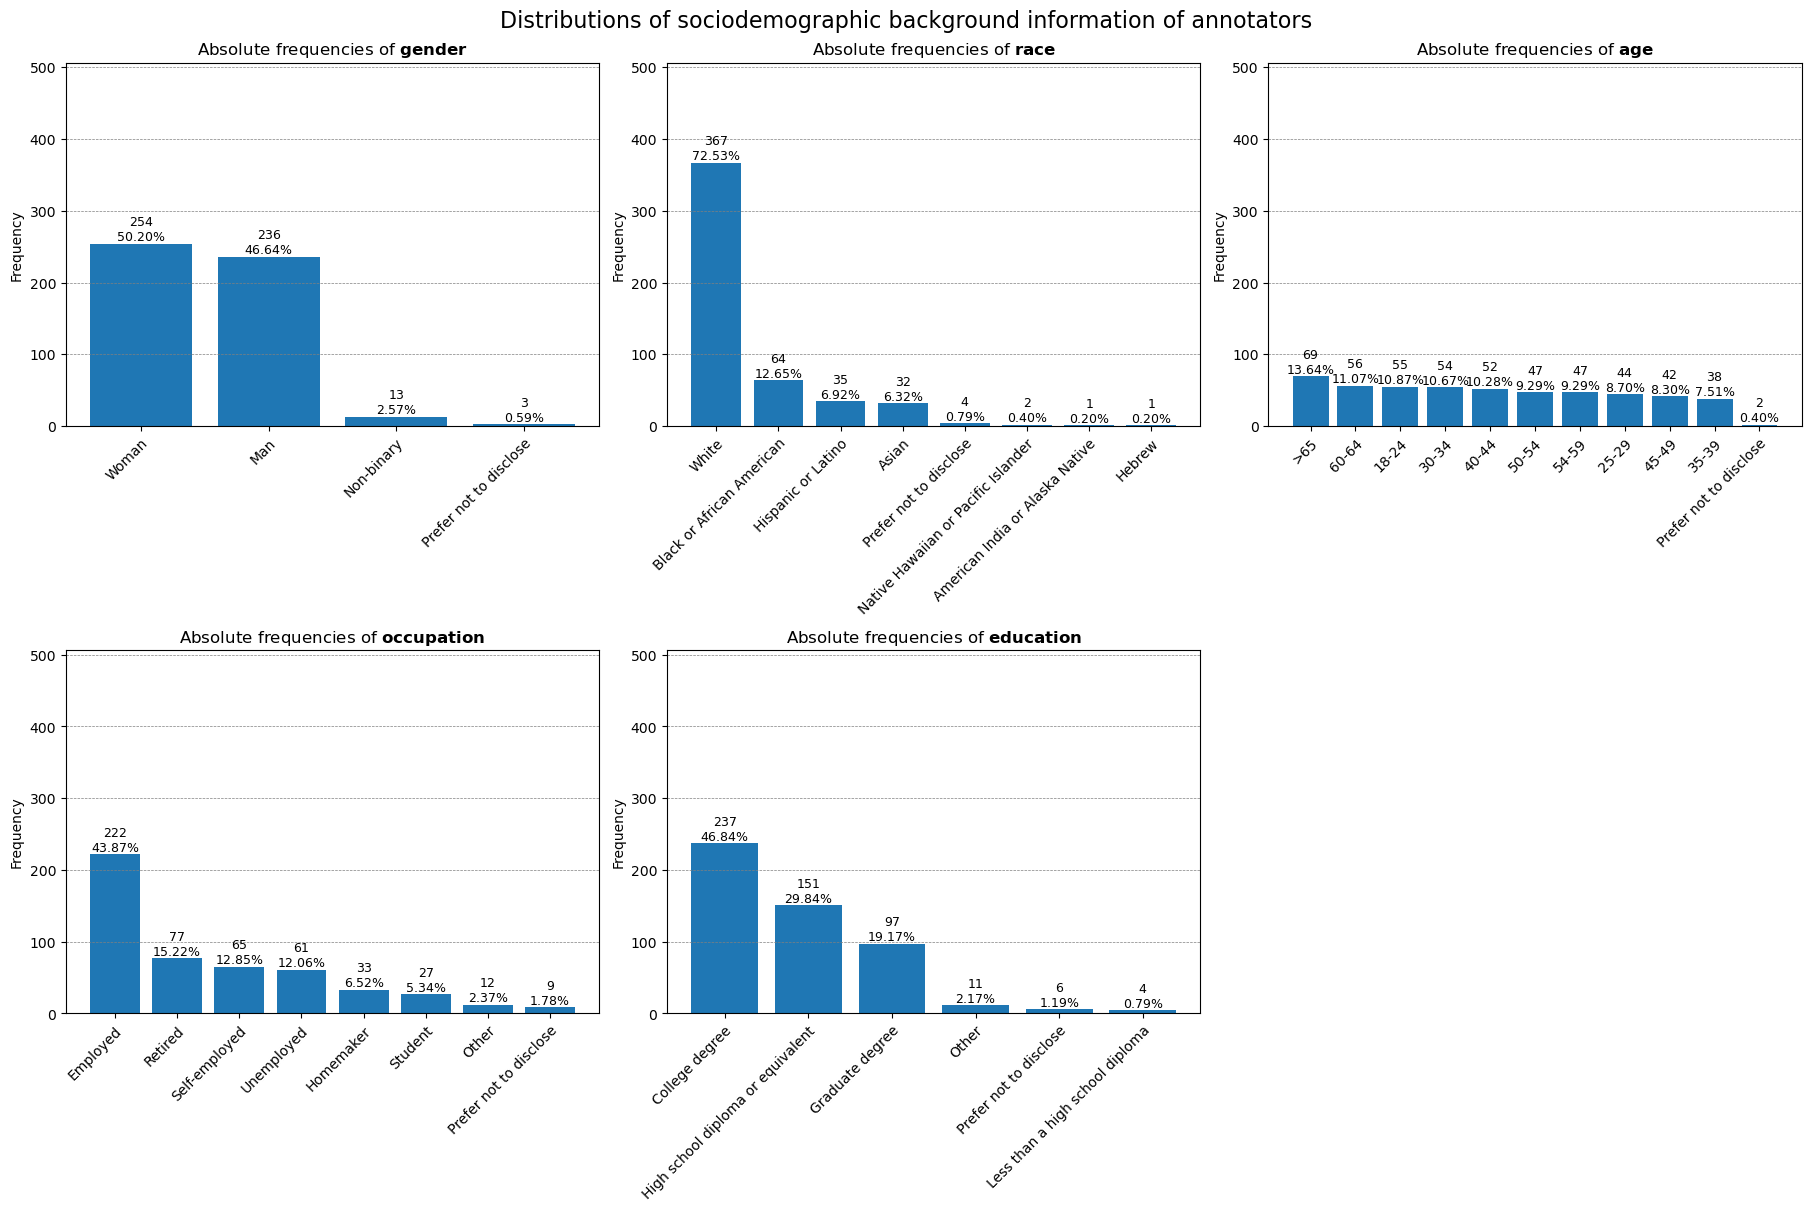

In [9]:
df_users = df.drop_duplicates('user_id') # count every annotator once only

# track the frequencies of each sociodemographic attribute's values
meta_dict = {attr: None for attr in df_users.columns[4:]}

fig, axes = plt.subplots(2, 3, figsize=(18,12), constrained_layout=True)
fig.suptitle("Distributions of sociodemographic background information of annotators", fontsize=16)
axes = axes.flatten()
axes[5].axis('off') # remove unused sixth subplot

for i, column in enumerate(df_users.columns[4:]):
    
    abs_freqs = df_users[column].value_counts()
    rel_freqs = df_users[column].value_counts(normalize=True)
  
    bars = axes[i].bar(abs_freqs.index, abs_freqs.values)
    axes[i].set_title(rf"Absolute frequencies of $\bf{{{column}}}$")
    axes[i].set_ylabel("Frequency")
    axes[i].set_ylim(0, num_annotr)
    
    meta_dict[column] = dict(map(lambda i,j : (i,j) , rel_freqs.index, rel_freqs.values))
    
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
        label.set_rotation_mode('anchor')

    # label the bars with the absolute and relative frequency values
    for bar, abs_freq, rel_freq in zip(bars, abs_freqs, rel_freqs):
        # save the frequencies for later
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{abs_freq}\n{rel_freq*100:.2f}%',
            ha='center',
            va='bottom',
            fontsize=9)    
    
    # add horizontal lines
    for y in axes[i].get_yticks():
        axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
        
plt.show()

### 4.3 Annotations, Disagreement

### 4.3.1 Example annotation distributions

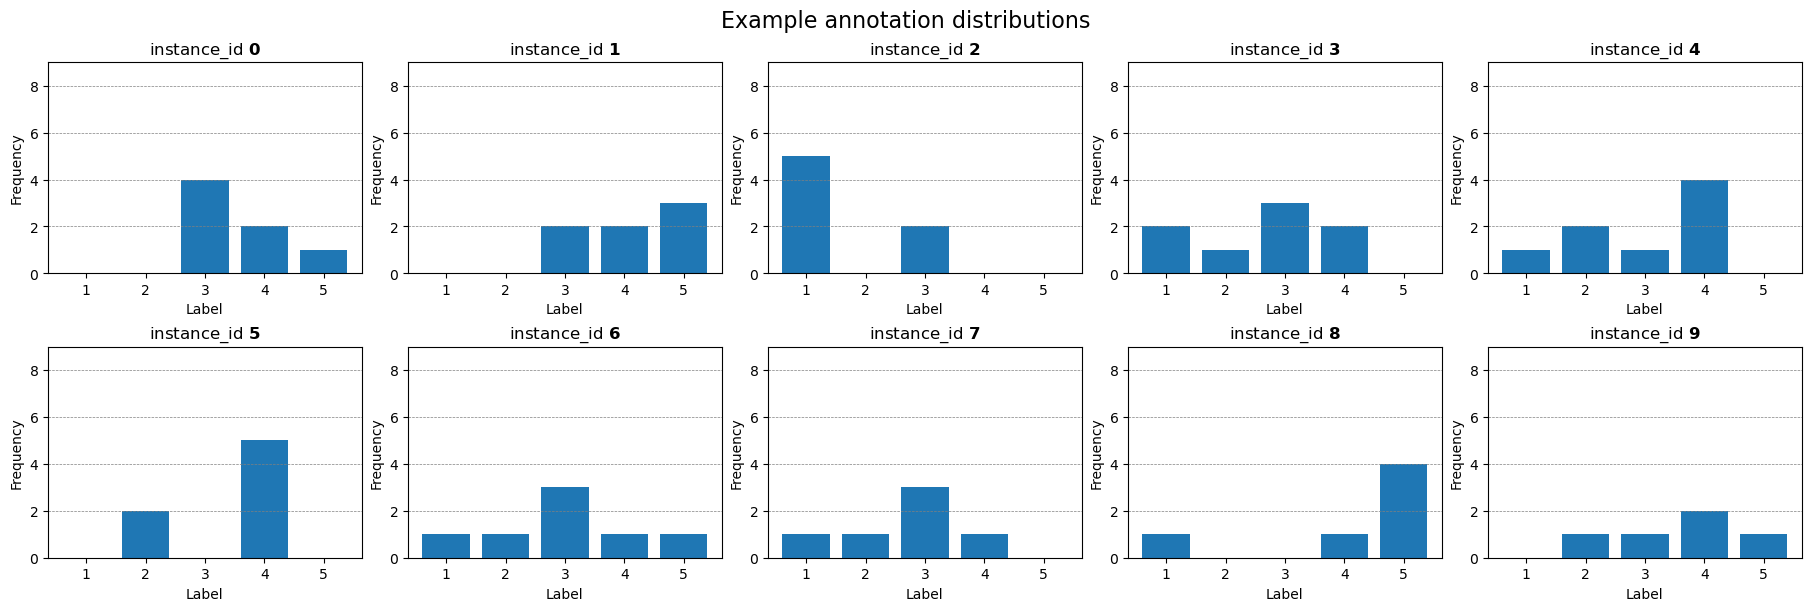

In [10]:
# Some example annotation distributions

df_poln = df.groupby('instance_id')['politeness'].apply(list).reset_index()

def aggregate_annotations(annotn):
    annotn_dict = dict.fromkeys(annotn_options, 0)
    for a in annotn:
        annotn_dict[a] += 1 
    return annotn_dict

def plot(ids, title):
    nrows = 2 if len(ids) > 5 else 1
    fig, axes = plt.subplots(nrows, 5, figsize=(18,3*nrows), constrained_layout=True)
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    
    for i, id in enumerate(ids):
        pltn = df_poln.loc[df_poln['instance_id'] == id, 'politeness'].iloc[0]
        annotn_dict = aggregate_annotations(pltn)

        bars = axes[i].bar(annotn_dict.keys(), annotn_dict.values())
        axes[i].set_title(rf"instance_id $\bf{{{id}}}$")
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel("Frequency")
        axes[i].set_ylim(0, num_annotn_per_inst.max()+1)

        # add horizontal lines
        for y in axes[i].get_yticks():
            axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.5)
    
    upper = int(sample_size/2) if nrows == 1 else sample_size
    for j in range(len(ids), upper):
        axes[j].axis('off')
    
    plt.show()
    
plot([i for i in range(sample_size)], "Example annotation distributions")

### 4.3.2 Perfect agreement

In [11]:
# Perfect agreement

perfect_agreement = df_poln[df_poln['politeness'].apply(lambda x: len(set(x)) == 1.0)]
perfect_agreement_besides_1 = perfect_agreement['politeness'].apply(lambda x: any(item != 1.0 for item in x))

print(f"Number of instances with perfect agreement: {len(perfect_agreement)}")
print(f"Number of instances with perfect agreement besides label 1.0: {len(perfect_agreement[perfect_agreement_besides_1])}")
print(f"Number of instances with disagreement: {num_inst - len(perfect_agreement)}")

Number of instances with perfect agreement: 67
Number of instances with perfect agreement besides label 1.0: 40
Number of instances with disagreement: 3651


### 4.3.3 Disagreement

[**Gini Index**](https://www.javatpoint.com/gini-index-in-machine-learning)

The Gini Index is a proportion of impurity or inequality in statistical and monetary settings. In machine learning, it is utilized as an impurity measure in decision tree algorithms for classification tasks. The higher, the more impure.

$$Gini = 1-\sum_{i=1}^n(p_i)^2$$


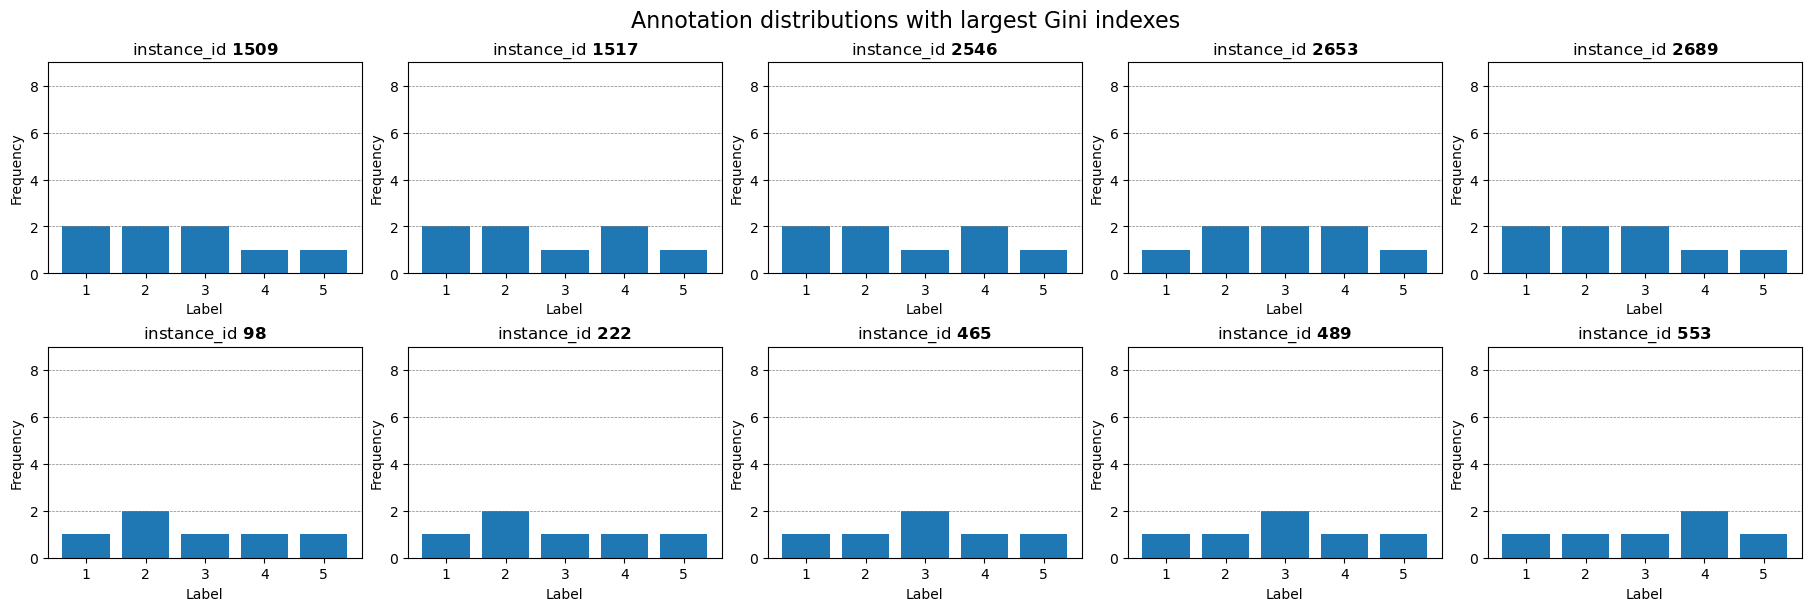

In [12]:
def calc_gini_index(annotn):
    sum_ = 0
    unique_vals = list(set(annotn))
    for val in unique_vals:
        sum_ += (annotn.count(val)/len(annotn))**2
    return round(1 - sum_, 3)

df_poln['gini_index'] = df_poln['politeness'].apply(calc_gini_index)
df_poln = df_poln.sort_values(by=['gini_index'], ascending=False, kind='stable')

plot(df_poln['instance_id'][:sample_size], "Annotation distributions with largest Gini indexes")

[**Krippendorff's $\alpha$**](https://github.com/pln-fing-udelar/fast-krippendorff/)

In [13]:
df_poln['value_counts'] = [
    [inst.count(i) for i in annotn_options] for inst in df_poln['politeness']
]

value_counts = np.array(df_poln['value_counts'].to_list())
print("Krippendorff's alpha:", krippendorff.alpha(value_counts=value_counts, level_of_measurement='ordinal'))

Krippendorff's alpha: 0.4270242390875326


[**Divergence**](https://aclanthology.org/2024.nlperspectives-1.7/)

Given a set of annotations for a given data instance $\{a_1, a_2, ..., a_N\}$,

the agreement $g_i$ for annotator $i \in [1,N]$ and the divergence $d$ are computed as follows ($g$ assumed to be an average in computing $d$):
$$g_i = \frac{1}{N}\sum_{i\neq j}a_i == a_j, \;\;\; \{g_1, g_2, ..., g_N\} =: g$$
$$d = 1-\frac{g}{max(g)} \in [0,1]$$

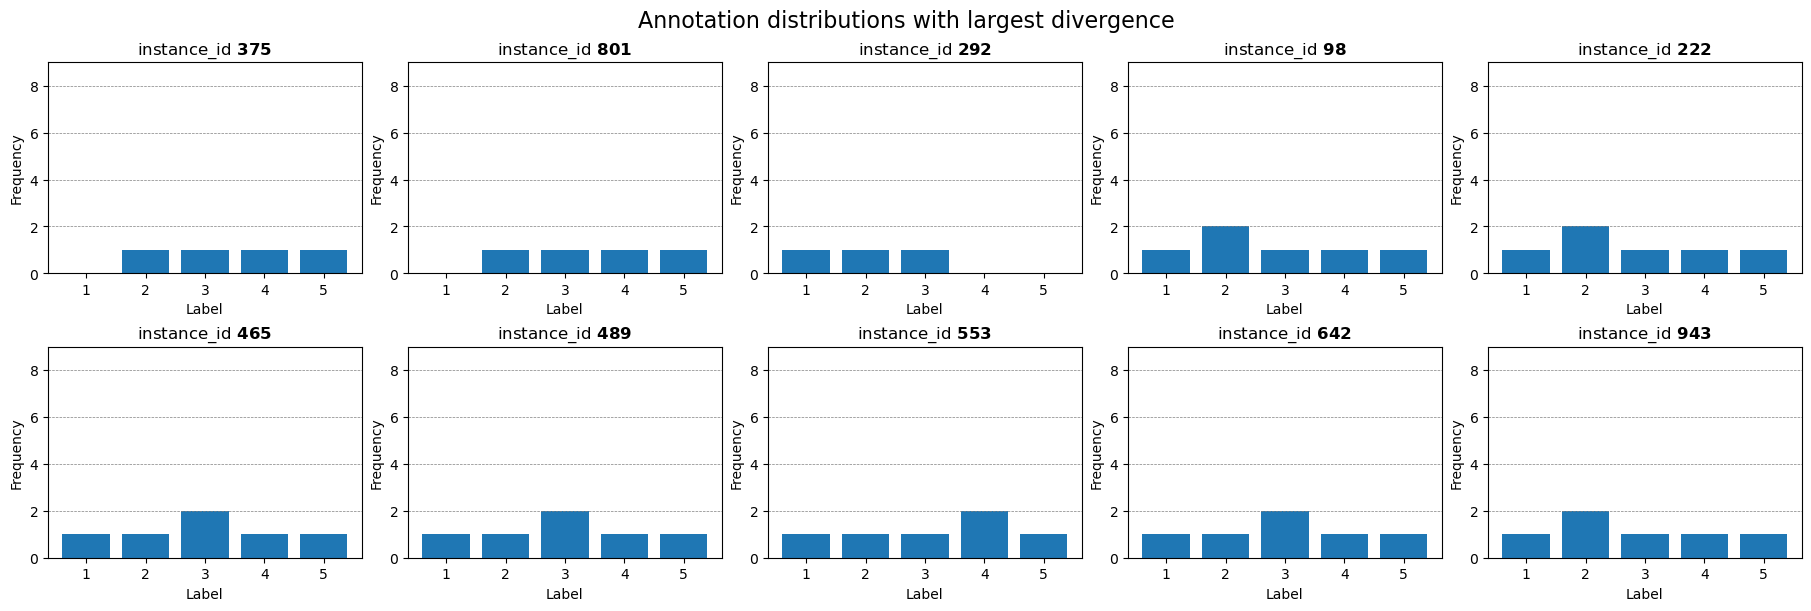

In [15]:
def calc_divergence(x):
    g = [x.count(i)-1 for i in x]
    # handle division by zero (complete disagreement, i.e. no repeat values -> g is all zeros)
    return 1 if max(g) == 0 else 1 - (sum(g)/len(g))/max(g)

df_poln['divergence'] = df_poln['politeness'].apply(calc_divergence)
df_poln = df_poln.sort_values(by=['divergence'], ascending=False, kind='stable')
plot(df_poln['instance_id'][:sample_size], "Annotation distributions with largest divergence")

**Inspect instances**

In [18]:
# Using the Gini index
degree = 'moderate'
ids = df_poln.sort_values(by=['gini_index'], ascending=False, kind='stable')['instance_id'][len(df_poln)//2:len(df_poln)//2+sample_size]
texts = df[df['instance_id'].isin(ids)][['instance_id', 'text']].drop_duplicates()
texts_dict = dict(zip(texts.instance_id, texts.text))

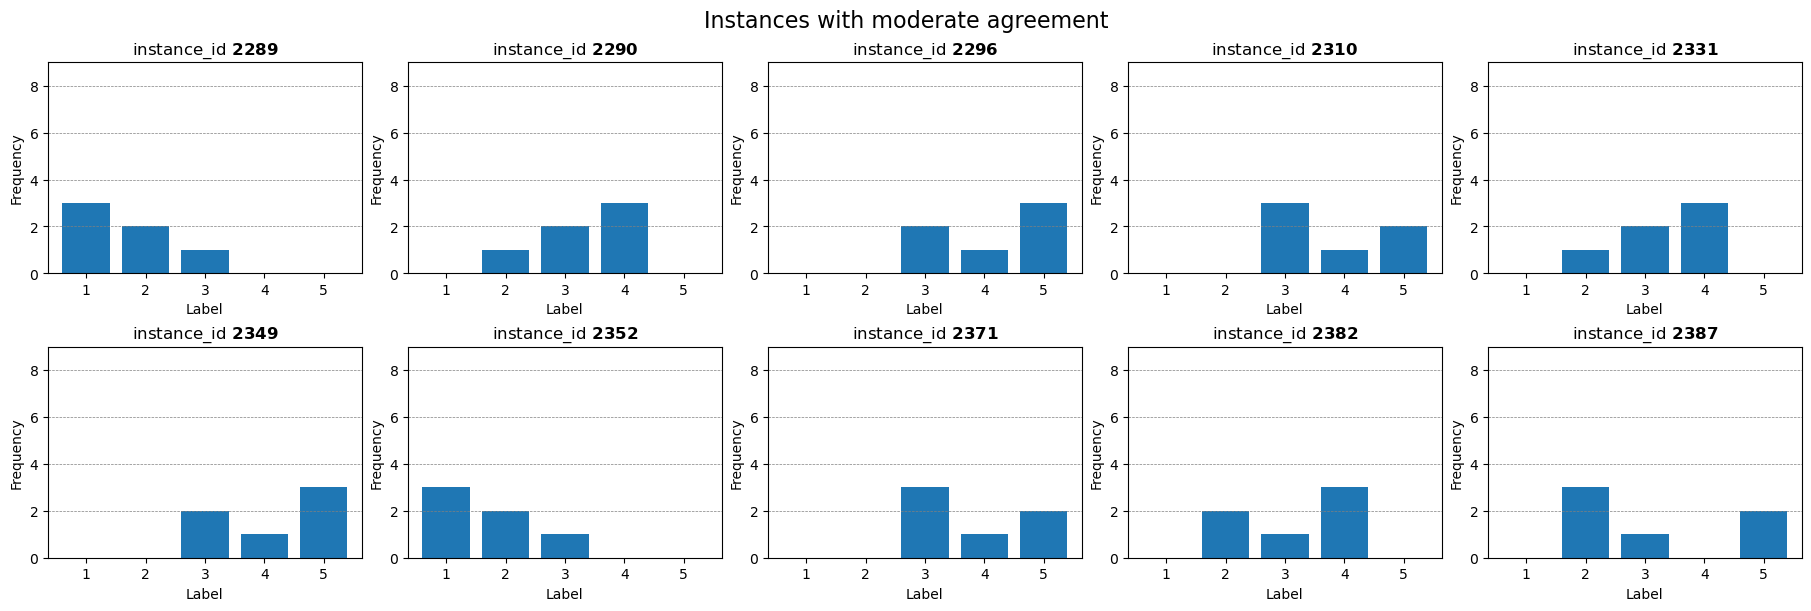

In [19]:
plot(ids, f"Instances with {degree} agreement")

In [ ]:
dir_name = 'extracted_texts'
file_name = f'texts_{degree}_agreement.json'
path_to_file = f'{dir_name}/{file_name}'
update = True # whether or not to update the file

if update:
    if os.path.exists(path_to_file) and os.path.getsize(path_to_file) > 0:
        with open(path_to_file) as f:
            texts_dict_ = json.load(f)
        texts_dict_['politeness'] = texts_dict
    else: 
        texts_dict_ = dict()
        texts_dict_['politeness'] = texts_dict

    with open(path_to_file, "w+") as f:
        json.dump(texts_dict_, f, indent=4)

### 4.3.4 Single majority label

Number of instances with a single majority for...
thresh = 1: 3017
thresh = 2: 1747
thresh = 3: 958
thresh = 4: 498
thresh = 5: 209


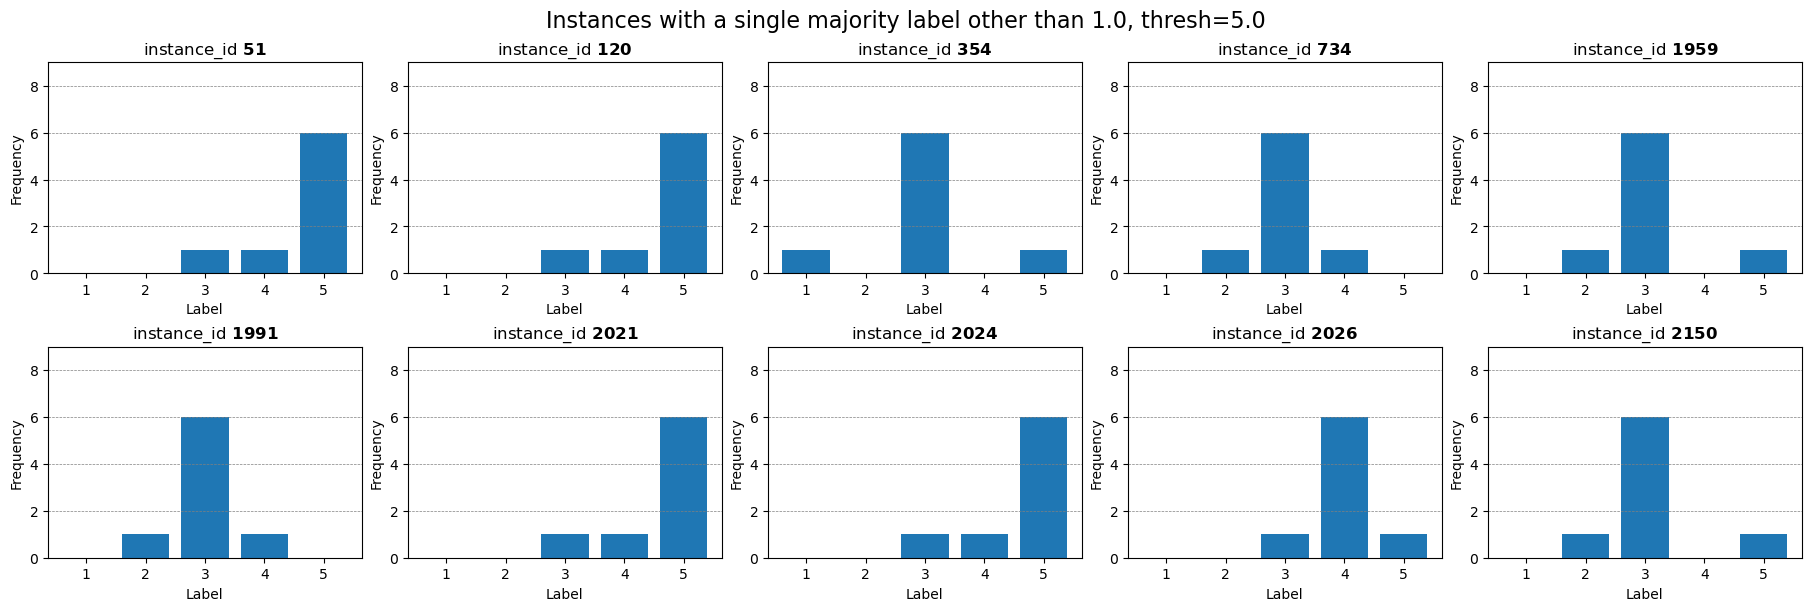

In [21]:
# Instances with a single majority

def get_majority_labels(d):
    max_value = max(d.values())
    # if there are multiple labels with the same highest count, return them all, though the single majority condition is not fulfilled
    maj_labels = [key for key, value in d.items() if value == max_value]
    return maj_labels[0] if len(maj_labels) == 1 else maj_labels

def has_single_majority(annotn, thresh):
    annotn_dict = dict.fromkeys(annotn_options, 0)
    for a in annotn:
        annotn_dict[a] += 1
    annotn_dict_sorted = dict(sorted(annotn_dict.items(), key=lambda x: x[1], reverse=True))
    counts = list(annotn_dict_sorted.values())
    majority_labels = get_majority_labels(annotn_dict_sorted)
    cond = counts[0] >= counts[1] + thresh
    return majority_labels, cond


verbose = False
print(f"Number of instances with a single majority for...")
for thresh in annotn_options:
    df_poln['tmp'] = df_poln['politeness'].apply(has_single_majority, thresh=thresh)
    df_poln[['majority_labels', 'has_single_majority']] = df_poln['tmp'].apply(pd.Series)
    df_poln.drop(columns=['tmp'], inplace=True)

    df_poln_maj = df_poln[df_poln.has_single_majority]
    print(f"thresh = {int(thresh)}: {len(df_poln_maj)}")
    
    distr = df_poln_maj['majority_labels'].value_counts().reset_index()
    if verbose: display(distr)
    
    if thresh == 5:
        ids = df_poln_maj.loc[df_poln_maj['majority_labels'] != 1.0, 'instance_id'][:sample_size]
        plot(ids, f"Instances with a single majority label other than 1.0, thresh={thresh}")
        if verbose: 
            with pd.option_context('display.max_colwidth', None):
                for id_ in ids:
                    display(df.loc[df['instance_id'] == id_][['text', 'politeness']].reset_index())

### 4.3.5 Annotation variety

In [22]:
# Annotation variety

# Aggregate the sociodem. meta information for each instance's annotators (for 1.3.6)
df_meta = df.groupby('instance_id').agg({
    'politeness': list,
    'gender': list,
    'race': list,
    'age': list,
    'occupation': list,
    'education': list
}).reset_index()

In [23]:
df_meta['num_different_labels'] = df_meta['politeness'].apply(lambda x: len(set(x)))
df_labels = df_meta['num_different_labels'].value_counts().reindex([1,2,3,4,5]).reset_index()
df_labels

,num_different_labels,count
0,1,67
1,2,757
2,3,1828
3,4,965
4,5,101


### 4.3.6 Links to sociodemographic background information

In [30]:
# for each of the five different numbers of different labels instances can have,
# go over all instances that apply and, for each value of each sociodemographic attribute, 
# sum up the frequencies in which they occur across those instances, overage them and compare it with the 
# true frequency in meta_dict.
def count_freqs(list_, attr, dict_):
    for val in dict_[attr].keys():
        dict_[attr][val] += list_.count(val) / len(list_)
    return dict_

meta_dict_full = dict()

for _, row in df_labels.iterrows():
    meta_dict_ = {attr: {val: 0 for val in meta_dict[attr].keys()} for attr in meta_dict.keys()}
    df_ = df_meta[df_meta['num_different_labels'] == row.iloc[0]]

    l = df_.columns.get_loc('gender')
    r = df_.columns.get_loc('education')
    for attr in df_.columns[l:r+1]:
        meta_dict_sums = df_[attr].apply(count_freqs, attr=attr, dict_=meta_dict_)
    
    meta_dict_sums = meta_dict_sums.iloc[0]
    for attr, val_dict in meta_dict_sums.items():
        meta_dict_sums[attr] = {k: v / row.iloc[1] for k, v in val_dict.items()}

    meta_dict_full[int(row.iloc[0])] = meta_dict_sums

In [ ]:
for i in meta_dict_full.keys():
    print(f"================= {i} different label(s) =================")
    print(json.dumps({
    outer_key: {key: meta_dict[outer_key][key] - meta_dict_full[i][outer_key][key] 
                for key in meta_dict[outer_key]} 
    for outer_key in meta_dict
    }, sort_keys=True, indent=4))

# value above 0 -> that attribute value has appeared less frequently than the average
# value below 0 -> that attribute value has appeared more frequently than the average